**Load Dataset**

In [36]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [23]:
# Install kaggle library
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"smmmmmmmm","key":"7b133f9532960b035175029dd9cafb37"}'}

In [24]:
# Move kaggle.json to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d shubh0799/churn-modelling

Dataset URL: https://www.kaggle.com/datasets/shubh0799/churn-modelling
License(s): CC0-1.0
  0% 0.00/262k [00:00<?, ?B/s]
100% 262k/262k [00:00<00:00, 58.6MB/s]


In [25]:
!unzip churn-modelling.zip

Archive:  churn-modelling.zip
  inflating: Churn_Modelling.csv     


In [26]:
data = pd.read_csv("Churn_Modelling.csv")

# Basic information about the dataset
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Data Cleaning**

In [27]:
# Drop irrelevant columns
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

**Exploratory Data Analysis**


---


Churn Distribution

<ipython-input-28-0e4254bbedc8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Exited', data=data, palette='coolwarm')


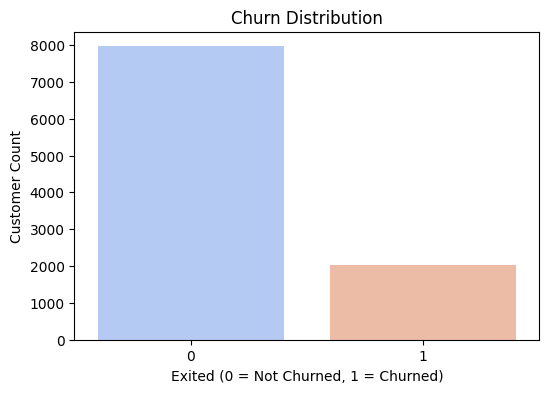

Churn Rate: 20.37% churned, 79.63% did not churn.


In [28]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=data, palette='coolwarm')
plt.title('Churn Distribution')
plt.xlabel('Exited (0 = Not Churned, 1 = Churned)')
plt.ylabel('Customer Count')
plt.show()

# Churn rate calculation
churn_rate = data['Exited'].value_counts(normalize=True) * 100
print(f"Churn Rate: {churn_rate[1]:.2f}% churned, {churn_rate[0]:.2f}% did not churn.")


Age Distribution for Churned vs Not Churned Customers

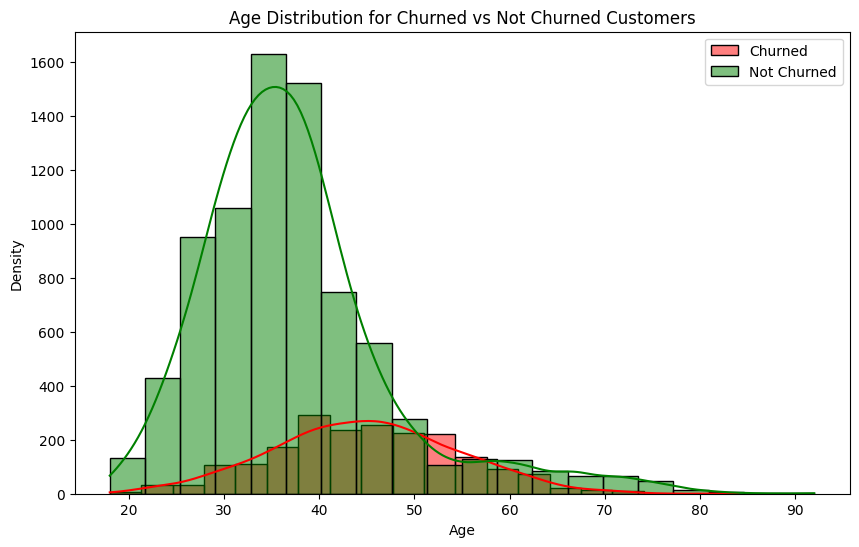

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(data[data['Exited'] == 1]['Age'], bins=20, color='red', label='Churned', kde=True)
sns.histplot(data[data['Exited'] == 0]['Age'], bins=20, color='green', label='Not Churned', kde=True)
plt.title('Age Distribution for Churned vs Not Churned Customers')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()


Churn by Geography

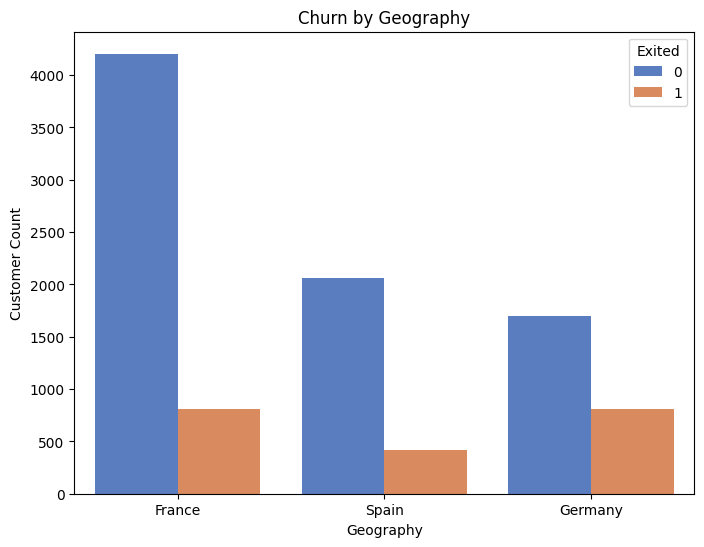


Churn Rate by Geography:
Geography
France     16.154767
Germany    32.443204
Spain      16.673395
Name: Exited, dtype: float64


In [30]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Geography', hue='Exited', data=data, palette='muted')
plt.title('Churn by Geography')
plt.xlabel('Geography')
plt.ylabel('Customer Count')
plt.show()

# Calculate churn rate by geography
geo_churn = data.groupby('Geography')['Exited'].mean() * 100
print("\nChurn Rate by Geography:")
print(geo_churn)


Focus marketing campaigns on Germany as it has the highest churn rates.

Account Balance and Churn

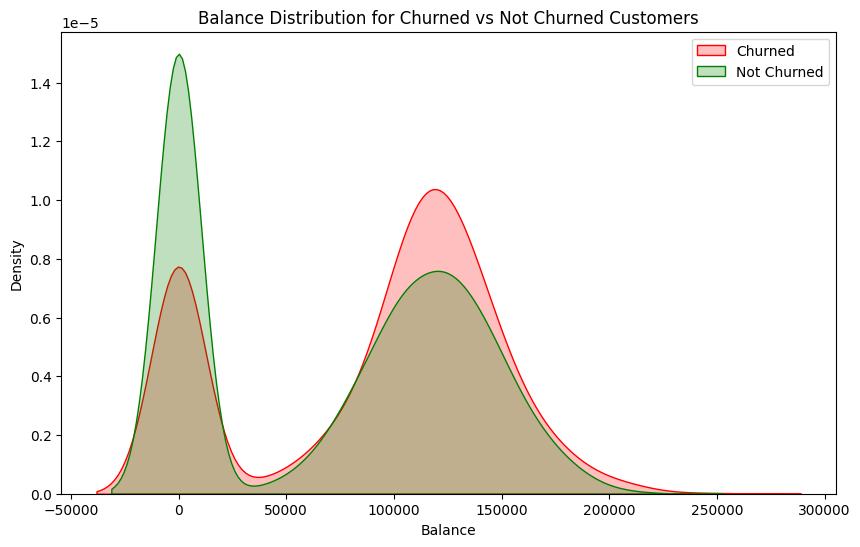

In [31]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data[data['Exited'] == 1]['Balance'], color='red', fill=True, label='Churned')
sns.kdeplot(data[data['Exited'] == 0]['Balance'], color='green', fill=True, label='Not Churned')
plt.title('Balance Distribution for Churned vs Not Churned Customers')
plt.xlabel('Balance')
plt.ylabel('Density')
plt.legend()
plt.show()


Customers with zero balance are more likely to churn, suggesting disengagement

Credit Score and Churn

<ipython-input-32-09cc400f620b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Exited', y='CreditScore', data=data, palette='coolwarm')


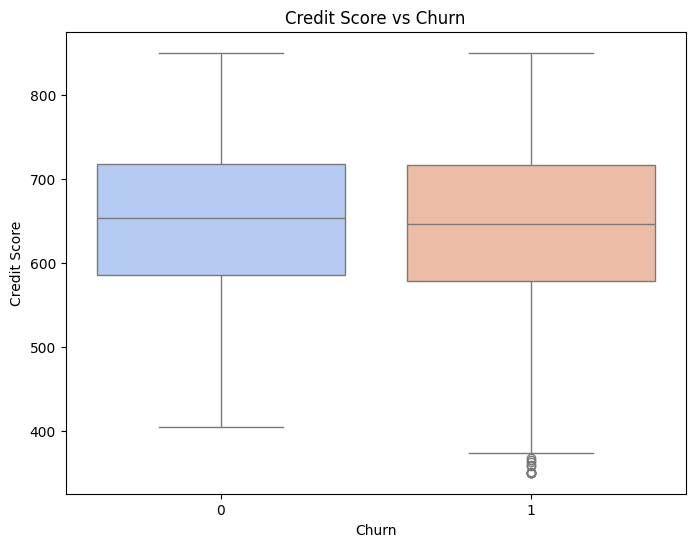

In [32]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Exited', y='CreditScore', data=data, palette='coolwarm')
plt.title('Credit Score vs Churn')
plt.xlabel('Churn')
plt.ylabel('Credit Score')
plt.show()


Correlation Heatmap

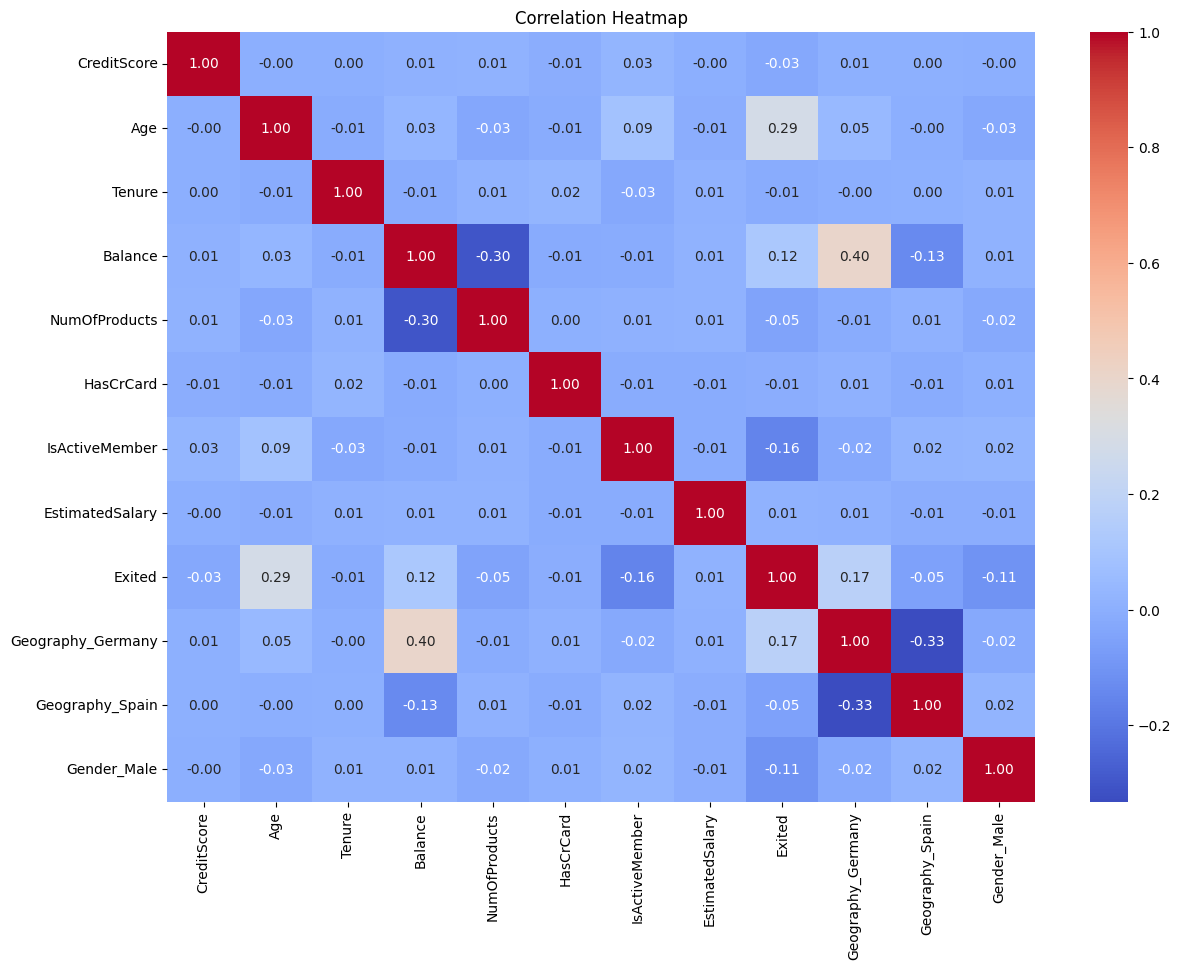

In [33]:
# Encode categorical variables for correlation analysis
encoded_data = pd.get_dummies(data, drop_first=True)

# Correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(encoded_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Look for strong correlations between Exited and features like Age, Balance, and IsActiveMember.

**Machine Learning Models**


---


Data Preprocessing

In [34]:
# Encode categorical variables
encoder = LabelEncoder()
data['Geography'] = encoder.fit_transform(data['Geography'])
data['Gender'] = encoder.fit_transform(data['Gender'])

# Scale numerical variables
scaler = StandardScaler()
numerical_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


Model Training


In [35]:
# Features and target
X = data.drop(columns=['Exited'])
y = data['Exited']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Random Forest

Random Forest is chosen for interpretability and strong performance on tabular data


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.78      0.46      0.58       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000

ROC AUC Score: 0.85


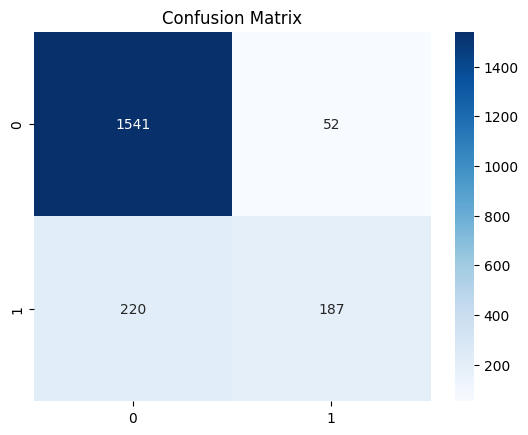

In [37]:
# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


Feature Importance

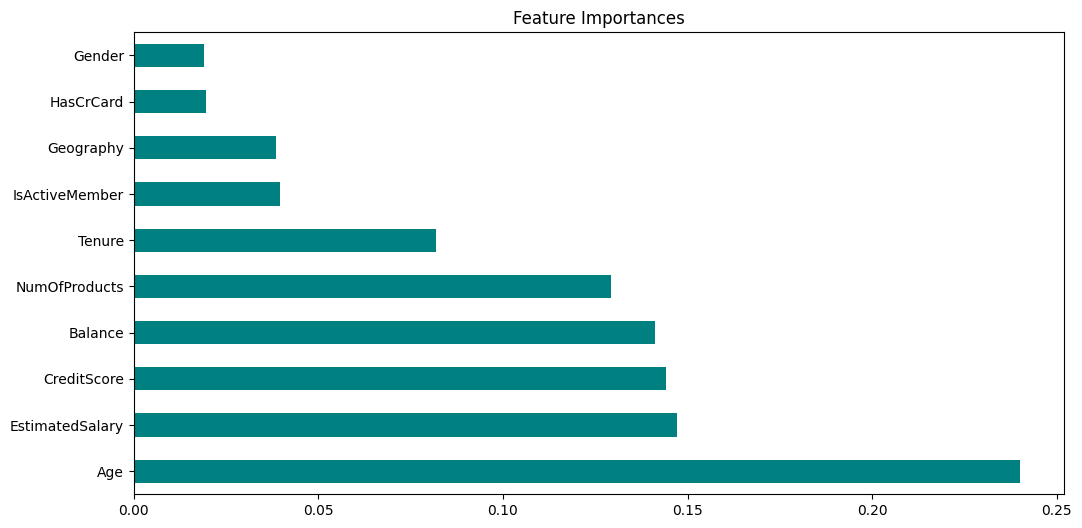

In [38]:
# Feature importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
importances.plot(kind='barh', color='teal')
plt.title('Feature Importances')
plt.show()


Features like Age, Credit Score, and Estimated Salary rank high for predicting churn